In [1]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np

% matplotlib inline

UsageError: Line magic function `%` not found.


## Data Representation & Operations for the NN

Class Value stores the data structures, operations and, most importantly,
the gradient calculation for each operation using the chain rule, and, 
the main backward function that uses topological sort and chains through each
backward function to get the gradients for each variable

In [2]:
class Value:

    def __init__(self, data, _children=[], _op=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None # Stores the derivative function for the particular operation

    def __repr__(self):
        return (f"Value={self.data}")
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data + other.data), [self, other], '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data), [self, other], '*')

        def _backward():
            self.grad += other.data * out.grad # if o = a*b, the do/da = b
            other.grad += self.data * out.grad # if o = a*b, the db/da = a
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def relu(self):
        out = Value((self.data if self.data > 0 else 0), [self,], 'ReLu')

        def _backward():
            self.grad += (1.0 if out.data > 0 else 0) * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):

        assert isinstance (other, (float, int))
        out = Value(self.data**other, [self,], f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        
        return out
    

    # Topological sorting to go from the output and move backwards to the initial input.
    # Then the backward function propagates through each node until the first
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0 # self.grad is 1.0 because self is the main output and the derivative of the output by the output is 1
        for node in reversed(topo):
            node._backward() 

## Making the Neural Network Class


In [3]:

# class Module is the way pyTorch implements their neural network class as well

class Module:

    def zero_grad(self): # To make all gradients 0 before back propagating during each optimization
        for p in self.parameters():
            p.grad = 0

    def parameters(self): # This is overriden by the parameters function of each child class—Neuron, Layer, MLP
        return []


# Each class has an __init__ function, __call__ function and parameters function

class Neuron(Module): # is a sub class of class Module

    def __init__(self, nin): #nin in this case is the number of input features (not the samples) and for each of the next layers, it's the number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((xi * wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer(Module):

    def __init__(self, nin, nout): # nout is the number of neurons in a single layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP(Module):

    def __init__(self, nin, nouts): #nouts will be a list of hidden and final layers like [3, 3, 1]
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



## A basic example with a small training set of float values

In [8]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [-1, 1, -1, 1]

n = MLP(3, [4,4,1])

for i in range(200):

    #Forward Pass
    preds = [n(x) for x in xs]
    # print(preds)

    #Loss function
    loss = sum((youts - yreal)**2 for yreal, youts in zip(ys, preds))

    #Gradient Zeroing
    for p in n.parameters():
        p.grad = 0.0

    #Backward Pass
    loss.backward()

    #Update weights
    for p in n.parameters():
        p.data += -0.01 * p.grad

    if i%5==0:
        print(i, loss.data)

print(n([2.0, 3.0, -1.0]))


0 7.085271302331204
5 5.583336878628488
10 4.322853365176939
15 3.3134708974187896
20 2.644180434799727
25 2.1308293857868517
30 1.7185125483381727
35 1.388743444324561
40 1.1238835035452426
45 0.9105898586194581
50 0.7396383553170363
55 0.6038079715485681
60 0.4967139921935431
65 0.4126213071400659
70 0.3465825211712559
75 0.2945255168995928
80 0.25321909232527906
85 0.22016191299544008
90 0.19344684316836042
95 0.17163152185920041
100 0.15362816273683375
105 0.13861545269655673
110 0.12597075298323987
115 0.11521913835822808
120 0.10599562072008437
125 0.09801734348264224
130 0.09106315938784462
135 0.08495861102658042
140 0.07956484253008281
145 0.07477036822301944
150 0.07048492144423213
155 0.06663482402146445
160 0.06315947345674247
165 0.06000865692677239
170 0.05714048120345891
175 0.05451976476611629
180 0.052116779348015105
185 0.04990625765428529
190 0.04786660533616714
195 0.04597927085234059
Value=-0.8727050172253312


In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    # print(v)
    if v not in nodes:
      nodes.add(v)
      # print(nodes)
      for child in v._prev:
        edges.add((child, v))
        # print(edges)
        build(child)
  build(root)
  # print(nodes, edges)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{data %.4f | grad %.4f}" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

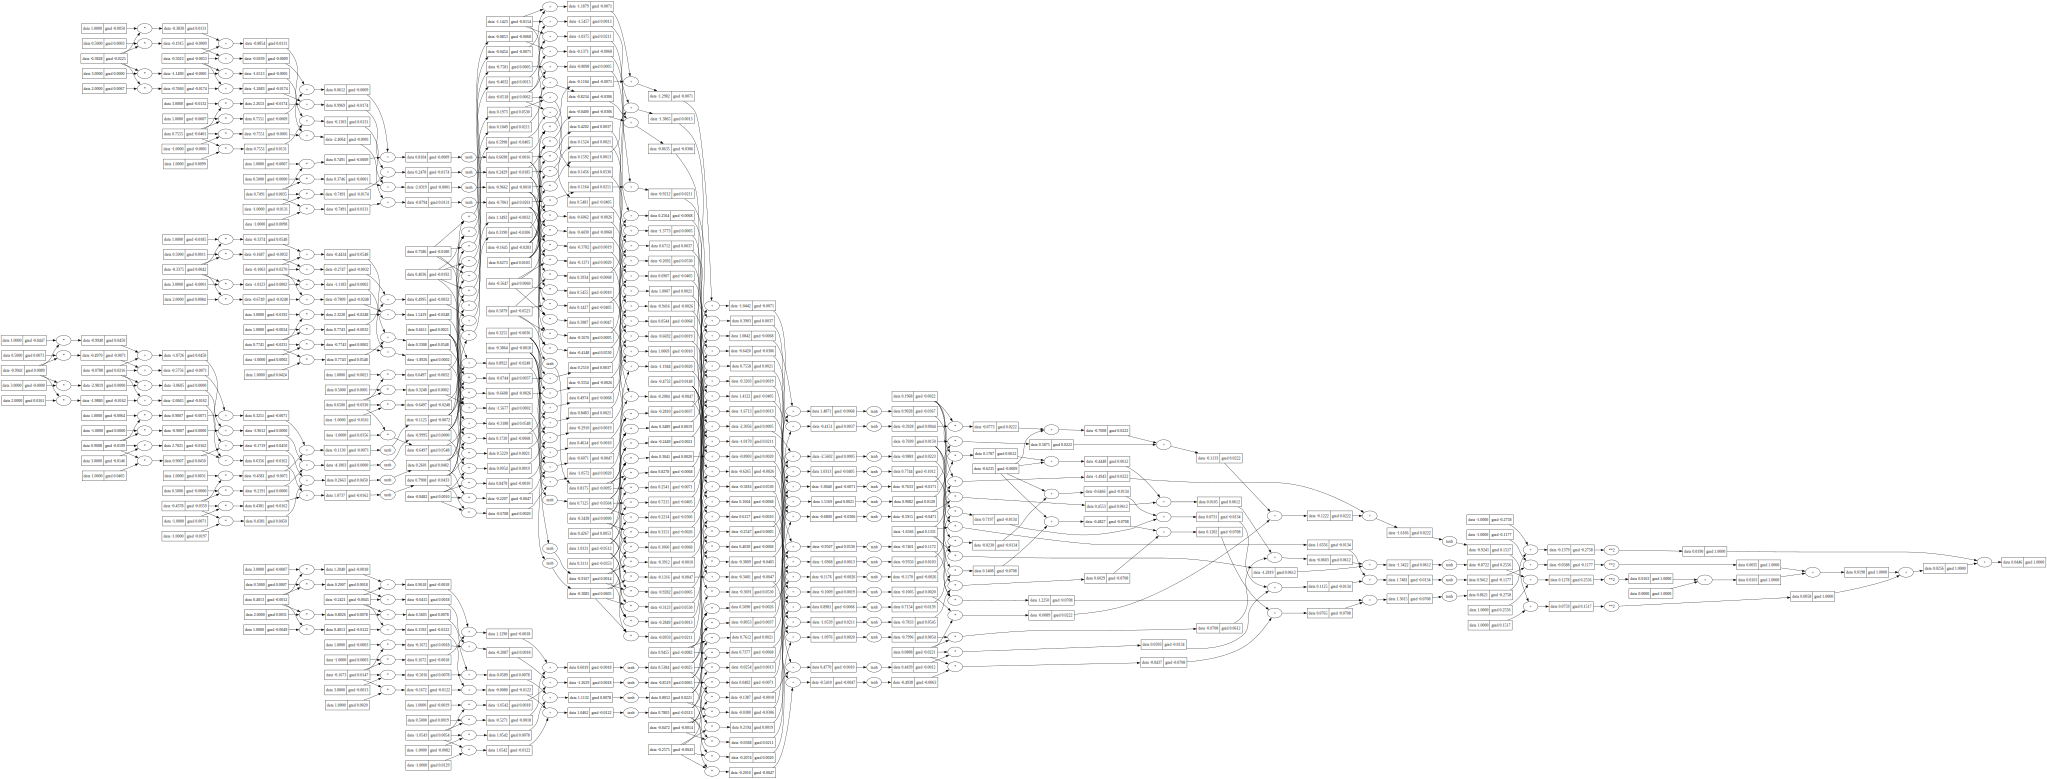

In [10]:
draw_dot(loss) #Drawing a computational graph

## An advanced example with an imported training set

number of parameters 337
step 0 loss 0.7840043023159259, accuracy 68.0%
step 1 loss 0.5346887893624206, accuracy 73.0%
step 2 loss 0.40486112398826374, accuracy 83.0%
step 3 loss 0.3380828095624803, accuracy 86.0%
step 4 loss 0.29426189790330415, accuracy 88.0%
step 5 loss 0.2713707188453524, accuracy 90.0%
step 6 loss 0.25577580370370173, accuracy 90.0%
step 7 loss 0.24353269446140008, accuracy 91.0%
step 8 loss 0.2331166633588174, accuracy 91.0%
step 9 loss 0.2237142971387503, accuracy 91.0%
step 10 loss 0.21478840620418216, accuracy 91.0%
step 11 loss 0.2060314219010388, accuracy 91.0%
step 12 loss 0.1972226427758724, accuracy 92.0%
step 13 loss 0.18824544635214924, accuracy 93.0%
step 14 loss 0.17902966856680738, accuracy 94.0%
step 15 loss 0.16967500545392206, accuracy 94.0%
step 16 loss 0.16033439848659783, accuracy 94.0%
step 17 loss 0.1520098627872637, accuracy 96.0%
step 18 loss 0.14550876426551523, accuracy 96.0%
step 19 loss 0.15276142639895773, accuracy 95.0%
step 20 loss 0

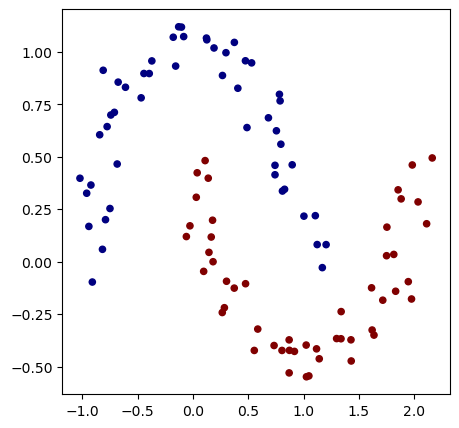

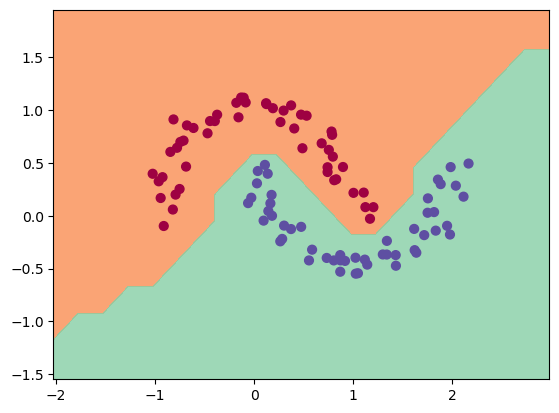

In [5]:

np.random.seed(1337)
random.seed(1337)

# make up a dataset
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    # print(inputs)
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    # scores = [model(x) for x in inputs]
    # print("scores:", scores)
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

# total_loss, acc = loss()


# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1-0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate*p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
        # print("Grads: ", model.parameters())


h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()